## Load dataset

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
#from imblearn.over_sampling import SMOTE 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score

In [2]:
#load the file
df = pd.read_excel('UT Comp_Seq.xlsx')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.gofplots import qqplot
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy import stats


## Clean Data
### 1. Remove Duplicate

In [3]:
dpl = sum(df.duplicated())
print("There is ",  dpl,  " duplicate") # no duplicate

There is  0  duplicate


### 2. Replace Na Values

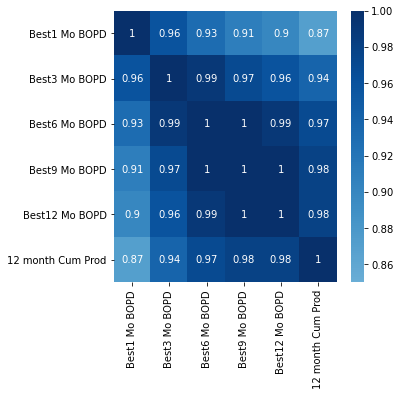

In [7]:
na_column = ['Best1 Mo BOPD', 'Best3 Mo BOPD', 'Best6 Mo BOPD',
       'Best9 Mo BOPD', 'Best12 Mo BOPD', '12 month Cum Prod']
corr_matrix = df[na_column].corr().round(2)
plt.figure(figsize=(5, 5))
sns.heatmap(corr_matrix, annot=True, vmax=1, vmin=0.85, center=.85, cmap='Blues')
plt.show()

#### Association between natural logarithmic variablee

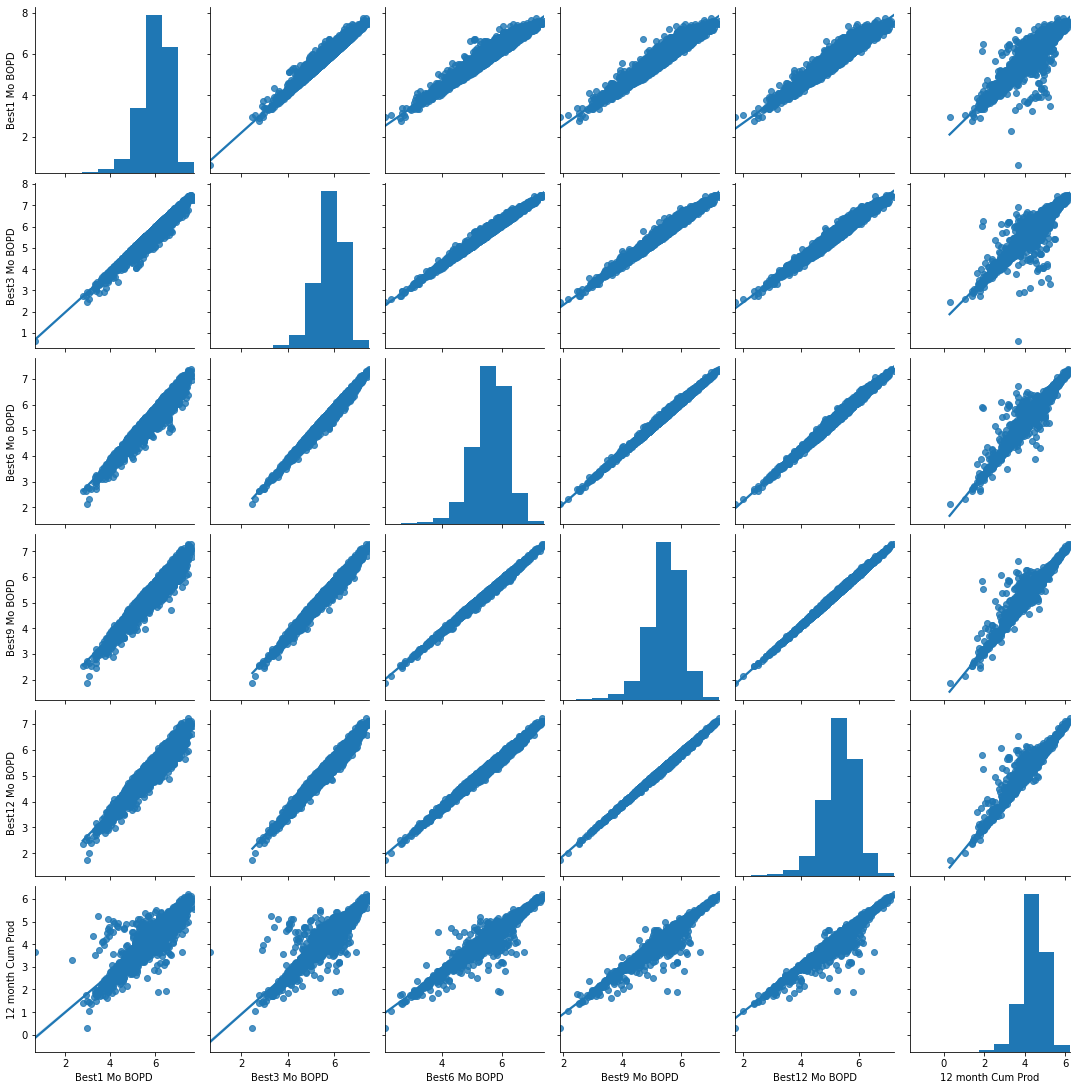

In [8]:
df_log = np.log(df[na_column])
sns.pairplot(df_log, kind="reg")
plt.show()

Because of non equal variance we use Natural Log 

#### Linear models for predicting Na values base on highest correlated varible

In [9]:
dflog_p01 = df_log[["Best1 Mo BOPD", "Best3 Mo BOPD"]].dropna()
model01 = LinearRegression().fit(dflog_p01["Best3 Mo BOPD"].values.reshape(-1,1),
                                dflog_p01["Best1 Mo BOPD"].values.reshape(-1,1))

In [10]:
dflog_p03 = df_log[["Best3 Mo BOPD", "Best6 Mo BOPD"]].dropna()
model03 = LinearRegression().fit(dflog_p03["Best6 Mo BOPD"].values.reshape(-1,1),
                                dflog_p03["Best3 Mo BOPD"].values.reshape(-1,1))

In [11]:
dflog_p06 = df_log[["Best6 Mo BOPD", "Best9 Mo BOPD"]].dropna()
model06 = LinearRegression().fit(dflog_p06["Best9 Mo BOPD"].values.reshape(-1,1),
                                dflog_p06["Best6 Mo BOPD"].values.reshape(-1,1))

In [12]:
dflog_p09 = df_log[["Best9 Mo BOPD", "Best12 Mo BOPD"]].dropna()
model09 = LinearRegression().fit(dflog_p09["Best12 Mo BOPD"].values.reshape(-1,1),
                                dflog_p09["Best9 Mo BOPD"].values.reshape(-1,1))

In [13]:
dflog_p12 = df_log[["Best12 Mo BOPD", "12 month Cum Prod"]].dropna()
model12 = LinearRegression().fit(dflog_p12["12 month Cum Prod"].values.reshape(-1,1),
                                dflog_p12["Best12 Mo BOPD"].values.reshape(-1,1))

# Apply each model to predecit the na valuse in each specific coloumn

In [14]:
df[na_column].isnull().sum()

Best1 Mo BOPD        1550
Best3 Mo BOPD        1656
Best6 Mo BOPD        2043
Best9 Mo BOPD        2464
Best12 Mo BOPD       2973
12 month Cum Prod       0
dtype: int64

In [15]:
# Replace 'Best12 Mo BOPD' na values
df["pred_p12"] = np.exp(model12.predict(np.log(df["12 month Cum Prod"].values.reshape(-1,1))))
df["Best12 Mo BOPD"] = np.where(df["Best12 Mo BOPD"].isnull(),
                                df["pred_p12"],
                                df["Best12 Mo BOPD"])

In [16]:
# Replace "Best09 Mo BOPD" na values
df["pred_p9"] = np.exp(model09.predict(np.log(df["Best12 Mo BOPD"].values.reshape(-1,1))))
df["Best9 Mo BOPD"] = np.where(df["Best9 Mo BOPD"].isnull(),
                                df["pred_p9"],
                                df["Best9 Mo BOPD"])

In [17]:
# Replace "Best06 Mo BOPD" na values
df["pred_p6"] = np.exp(model06.predict(np.log(df["Best9 Mo BOPD"].values.reshape(-1,1))))
df["Best6 Mo BOPD"] = np.where(df["Best6 Mo BOPD"].isnull(),
                                df["pred_p6"],
                                df["Best6 Mo BOPD"])

In [18]:
# Replace "Best03 Mo BOPD" na values
df["pred_p3"] = np.exp(model03.predict(np.log(df["Best6 Mo BOPD"].values.reshape(-1,1))))
df["Best3 Mo BOPD"] = np.where(df["Best3 Mo BOPD"].isnull(),
                                df["pred_p3"],
                                df["Best3 Mo BOPD"])

In [19]:
# Replace "Best01 Mo BOPD" na values
df["pred_p1"] = np.exp(model01.predict(np.log(df["Best3 Mo BOPD"].values.reshape(-1,1))))
df["Best1 Mo BOPD"] = np.where(df["Best1 Mo BOPD"].isnull(),
                                df["pred_p1"],
                                df["Best1 Mo BOPD"])

In [20]:
df[na_column].isnull().sum()

Best1 Mo BOPD        0
Best3 Mo BOPD        0
Best6 Mo BOPD        0
Best9 Mo BOPD        0
Best12 Mo BOPD       0
12 month Cum Prod    0
dtype: int64

# Create 'frac design' parameter

In [21]:
## Creating new variable "Stage Length" = LL/Stages

df['frac_design'] = df['Total Prop, lbs']/(df['Fluid, bbls']*42)

## Creating new variable "Stage Length" = LL/Stages

In [22]:
## Creating new variable "Stage Length" = LL/Stages

df['stage_length'] = df['Lateral Length']/df['Stages']

In [23]:
# add the count of complType to dataframe
df['ComplType_counts'] = df.groupby(['Compl. Type'])['12 month Cum Prod'].transform('count')

In [24]:
ComplType_unique = df["ComplType_counts"].unique()
print(sorted(ComplType_unique,
            reverse = True))

[4244.0, 3340.0, 1503.0, 687.0, 565.0, nan, 52.0, 26.0, 22.0, 20.0, 18.0, 16.0, 13.0, 10.0, 8.0, 6.0, 5.0, 4.0, 3.0, 2.0, 1.0]


In [25]:
# replce the ComplType_counts < 50 with "other" 
df['ComplType_new'] = np.where(df['ComplType_counts'] < 500 , "others", df['Compl. Type'])
df['ComplType_new'].value_counts(dropna = False)

Sleeves         4244
P & P           3340
P & P (cmt.)    1503
OH               687
No Data          565
others           427
NaN               90
Name: ComplType_new, dtype: int64

In [26]:
df['Compl. Type']

0                  OH
1                  OH
2                  OH
3             Sleeves
4                  OH
             ...     
10851    P & P (cmt.)
10852         Sleeves
10853    P & P (cmt.)
10854         Sleeves
10855           P & P
Name: Compl. Type, Length: 10856, dtype: object

In [27]:
df['ComplType_counts']

0         687.0
1         687.0
2         687.0
3        4244.0
4         687.0
          ...  
10851    1503.0
10852    4244.0
10853    1503.0
10854    4244.0
10855    3340.0
Name: ComplType_counts, Length: 10856, dtype: float64

In [28]:
df['ComplType_new']

0                  OH
1                  OH
2                  OH
3             Sleeves
4                  OH
             ...     
10851    P & P (cmt.)
10852         Sleeves
10853    P & P (cmt.)
10854         Sleeves
10855           P & P
Name: ComplType_new, Length: 10856, dtype: object

In [29]:
# replace the nan value with "No Data"
df["ComplType_new"] = np.where(df["ComplType_new"].isnull(), "No Data" , df["ComplType_new"])
df['ComplType_new'].value_counts(dropna = False)

Sleeves         4244
P & P           3340
P & P (cmt.)    1503
OH               687
No Data          655
others           427
Name: ComplType_new, dtype: int64

In [31]:
df.Formation.value_counts()

MBH        7065
TFH        3576
TF2          82
MBH/TFH      58
TF1          33
TF3          16
UTFH          6
MTFH          4
TFSH          4
TF4           2
TF2.5         2
Name: Formation, dtype: int64

In [43]:
dfx = df.loc[df['Formation'].isin(['MBH', 'TFH'])]

In [45]:
dfx.Formation.value_counts()

MBH    7065
TFH    3576
Name: Formation, dtype: int64

# Random Forest

In [46]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV 

In [53]:
dfx.head()

,Operator,Well Name,Formation,Lateral Length,Stages,Township,Range,Section,"Total Prop, lbs","Fluid, bbls",...,12 month Cum Prod,pred_p12,pred_p9,pred_p6,pred_p3,pred_p1,frac_design,stage_length,ComplType_counts,ComplType_new
0,Operator 7,Well 92,MBH,9707.0,21.0,143,98,35,1283184.0,31638.333333,...,34.41,96.818378,102.047848,119.506653,146.064385,166.125539,0.965664,462.238095,687.0,OH
1,Operator 7,Well 288,TFH,8990.0,21.0,160,91,5,2094358.0,57618.000000,...,19.19,55.323234,95.886419,106.428055,124.816977,135.291324,0.865453,428.095238,687.0,OH
2,Operator 7,Well 326,MBH,8659.0,21.0,160,90,21,2162180.0,58524.000000,...,46.16,128.300066,155.121739,166.154818,182.214054,195.293021,0.879647,412.333333,687.0,OH
3,Operator 7,Well 1722,MBH,9623.0,21.0,142,95,11,1708145.0,62146.000000,...,33.65,94.768075,98.065040,113.405894,133.530707,159.815493,0.654429,458.238095,4244.0,Sleeves
4,Operator 7,Well 1852,MBH,8541.0,21.0,142,95,36,2134416.0,52873.000000,...,25.20,71.830096,69.132125,75.967676,87.483332,97.572433,0.961160,406.714286,687.0,OH


In [54]:
import warnings
warnings.filterwarnings("ignore")

In [55]:
dfx.isnull().values.any()

True

In [56]:
dfx.isnull().sum().sum()

6330

In [58]:
dfx.describe()

,Lateral Length,Stages,Township,Range,Section,"Total Prop, lbs","Fluid, bbls",Best1 Mo BOPD,Best3 Mo BOPD,Best6 Mo BOPD,...,SPACING_CAPPED,12 month Cum Prod,pred_p12,pred_p9,pred_p6,pred_p3,pred_p1,frac_design,stage_length,ComplType_counts
count,10639.000000,10485.000000,10641.000000,10641.000000,10641.000000,1.064100e+04,10630.000000,10641.000000,10641.000000,10641.000000,...,10632.000000,10641.000000,10641.000000,10641.000000,10641.000000,10641.000000,10641.000000,1.051900e+04,10485.000000,10557.000000
mean,8906.803609,27.941726,152.169345,95.923222,18.150362,3.320781e+06,68889.397988,521.466717,418.994691,343.302209,...,599.187434,98.376841,263.479100,297.469307,344.282970,421.573471,520.563793,inf,676.698520,2990.026523
std,1834.346572,10.955946,4.858011,3.490216,10.454545,2.356732e+06,57967.852045,287.687826,228.815932,185.970127,...,107.771805,54.022587,138.375694,160.622427,187.019737,230.020847,285.320312,NaN,1678.412062,1404.051889
min,3.000000,1.000000,139.000000,89.000000,1.000000,0.000000e+00,0.000000,1.702215,1.399267,1.186603,...,25.971590,0.280000,0.962569,1.058439,1.186603,1.399267,1.702215,0.000000e+00,3.000000,1.000000
25%,8909.500000,22.000000,149.000000,93.000000,9.000000,1.998764e+06,34608.000000,309.566075,253.451677,211.165900,...,581.913968,61.010000,167.617145,186.491310,213.803863,258.183189,314.160233,1.020716e+00,269.971429,1503.000000
50%,9425.000000,30.000000,152.000000,96.000000,18.000000,2.950665e+06,54959.500000,479.783037,383.048433,311.752137,...,660.000000,88.970000,240.624116,268.907486,310.782331,382.203514,475.506525,1.265901e+00,313.266667,3340.000000
75%,9797.500000,34.000000,155.000000,99.000000,27.000000,3.860820e+06,79678.000000,678.768282,538.428665,439.195705,...,660.000000,124.740000,332.652366,377.992150,438.644505,539.737276,669.212715,1.596131e+00,368.240000,4244.000000
max,22231.000000,94.000000,164.000000,105.000000,36.000000,2.874457e+07,598562.000000,2385.562147,1910.606826,1635.179706,...,660.000000,495.810000,1248.380338,1569.599319,1704.011050,2028.034059,2385.562147,inf,22231.000000,4244.000000


In [60]:
dfx = dfx[dfx['Fluid, bbls'] > 0]

In [63]:
dfx.isnull().values.any()

True

In [64]:
dfx.isnull().sum().sum()

5831

In [74]:
df.isnull().sum()

Operator                 0
Well Name                0
Formation                8
Lateral Length           8
Stages                 168
Township                 0
Range                    0
Section                  0
Total Prop, lbs          0
Fluid, bbls             17
Date Fracd               8
Best1 Mo BOPD            0
Best3 Mo BOPD            0
Best6 Mo BOPD            0
Best9 Mo BOPD            0
Best12 Mo BOPD           0
Compl. Type             90
Latitude                 0
Longitude                0
Fluid Type from DI    5776
SPACING_CAPPED           9
12 month Cum Prod        0
pred_p12                 0
pred_p9                  0
pred_p6                  0
pred_p3                  0
pred_p1                  0
frac_design            132
stage_length           168
ComplType_counts        90
ComplType_new            0
dtype: int64

In [78]:
df.Stages.value_counts()

30.0    2437
35.0     724
1.0      447
36.0     410
32.0     403
        ... 
94.0       1
90.0       1
81.0       1
89.0       1
71.0       1
Name: Stages, Length: 82, dtype: int64

In [80]:
dfx

,Operator,Well Name,Formation,Lateral Length,Stages,Township,Range,Section,"Total Prop, lbs","Fluid, bbls",...,12 month Cum Prod,pred_p12,pred_p9,pred_p6,pred_p3,pred_p1,frac_design,stage_length,ComplType_counts,ComplType_new
0,Operator 7,Well 92,MBH,0.436566,0.215054,143,98,35,0.044641,0.050209,...,34.41,96.818378,102.047848,119.506653,146.064385,166.125539,0.028757,0.020660,687.0,OH
1,Operator 7,Well 288,TFH,0.404310,0.215054,160,91,5,0.072861,0.093734,...,19.19,55.323234,95.886419,106.428055,124.816977,135.291324,0.025773,0.019124,687.0,OH
2,Operator 7,Well 326,MBH,0.389419,0.215054,160,90,21,0.075220,0.095252,...,46.16,128.300066,155.121739,166.154818,182.214054,195.293021,0.026196,0.018415,687.0,OH
3,Operator 7,Well 1722,MBH,0.432787,0.215054,142,95,11,0.059425,0.101320,...,33.65,94.768075,98.065040,113.405894,133.530707,159.815493,0.019489,0.020480,4244.0,Sleeves
4,Operator 7,Well 1852,MBH,0.384110,0.215054,142,95,36,0.074255,0.085784,...,25.20,71.830096,69.132125,75.967676,87.483332,97.572433,0.028623,0.018162,687.0,OH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10851,Operator 4,Well 10829,MBH,0.423610,0.258065,159,97,5,0.098234,0.131965,...,28.65,81.228862,90.764094,104.393064,127.010612,157.041373,0.024890,0.016815,1503.0,P & P (cmt.)
10852,Operator 18,Well 10834,TFH,0.435577,0.526882,155,96,24,0.174030,0.115780,...,109.08,292.520147,328.377151,380.488995,467.123170,580.289815,0.050114,0.008579,4244.0,Sleeves
10853,Operator 4,Well 10837,MBH,0.437016,0.387097,155,99,33,0.230591,0.300345,...,202.44,529.084953,595.214942,692.035604,853.161563,1062.155549,0.025973,0.011680,1503.0,P & P (cmt.)
10854,Operator 18,Well 10839,MBH,0.438501,0.365591,155,96,24,0.121438,0.005294,...,56.58,155.934949,174.651379,201.634251,246.449787,305.450344,0.512533,0.012397,4244.0,Sleeves


In [81]:
dfy = dfx.dropna()

In [82]:
dfy

,Operator,Well Name,Formation,Lateral Length,Stages,Township,Range,Section,"Total Prop, lbs","Fluid, bbls",...,12 month Cum Prod,pred_p12,pred_p9,pred_p6,pred_p3,pred_p1,frac_design,stage_length,ComplType_counts,ComplType_new
0,Operator 7,Well 92,MBH,0.436566,0.215054,143,98,35,0.044641,0.050209,...,34.41,96.818378,102.047848,119.506653,146.064385,166.125539,0.028757,0.020660,687.0,OH
1,Operator 7,Well 288,TFH,0.404310,0.215054,160,91,5,0.072861,0.093734,...,19.19,55.323234,95.886419,106.428055,124.816977,135.291324,0.025773,0.019124,687.0,OH
2,Operator 7,Well 326,MBH,0.389419,0.215054,160,90,21,0.075220,0.095252,...,46.16,128.300066,155.121739,166.154818,182.214054,195.293021,0.026196,0.018415,687.0,OH
3,Operator 7,Well 1722,MBH,0.432787,0.215054,142,95,11,0.059425,0.101320,...,33.65,94.768075,98.065040,113.405894,133.530707,159.815493,0.019489,0.020480,4244.0,Sleeves
4,Operator 7,Well 1852,MBH,0.384110,0.215054,142,95,36,0.074255,0.085784,...,25.20,71.830096,69.132125,75.967676,87.483332,97.572433,0.028623,0.018162,687.0,OH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5073,Operator 6,Well 7469,MBH,0.408674,0.311828,158,91,16,0.120007,0.108014,...,68.20,186.503622,211.501043,229.338973,264.639199,322.993788,0.036979,0.013492,4244.0,Sleeves
5074,Operator 18,Well 7492,MBH,0.420101,0.397849,155,93,32,0.138826,0.136735,...,170.60,449.057994,510.687563,614.642967,785.386502,1030.660446,0.033973,0.010924,4244.0,Sleeves
5077,Operator 2,Well 8983,MBH,0.439761,0.247312,157,96,2,0.090591,0.109281,...,53.70,148.319921,171.253473,197.427078,240.163646,283.127354,0.027599,0.018194,3340.0,P & P
5078,Operator 6,Well 10668,MBH,0.401251,0.311828,154,99,18,0.114297,0.106515,...,84.92,230.116630,272.506002,322.362381,406.450487,514.665132,0.035703,0.013245,4244.0,Sleeves


In [62]:
dfx.describe()


,Lateral Length,Stages,Township,Range,Section,"Total Prop, lbs","Fluid, bbls",Best1 Mo BOPD,Best3 Mo BOPD,Best6 Mo BOPD,...,SPACING_CAPPED,12 month Cum Prod,pred_p12,pred_p9,pred_p6,pred_p3,pred_p1,frac_design,stage_length,ComplType_counts
count,10412.000000,10341.000000,10414.00000,10414.000000,10414.000000,1.041400e+04,10414.000000,10414.000000,10414.000000,10414.000000,...,10406.000000,10414.000000,10414.000000,10414.000000,10414.000000,10414.000000,10414.000000,10414.000000,10341.000000,10337.000000
mean,8926.441183,28.165651,152.16401,95.933551,18.157672,3.379771e+06,70318.254332,523.587962,420.555609,344.519415,...,598.571987,98.737745,264.432253,298.345195,345.402936,423.072230,522.506331,1.333905,641.058898,3032.301828
std,1796.029900,10.732898,4.85004,3.490119,10.443020,2.336974e+06,57701.738891,287.116913,228.292250,185.342774,...,108.017010,53.792563,137.754977,159.706694,186.181509,229.252948,284.673181,0.664371,1589.316336,1378.361550
min,3.000000,1.000000,139.00000,89.000000,1.000000,0.000000e+00,1669.000000,1.702215,1.399267,1.186603,...,25.971590,0.280000,0.962569,1.058439,1.186603,1.399267,1.702215,0.000000,3.000000,1.000000
25%,8931.750000,23.000000,149.00000,93.000000,9.000000,2.046015e+06,36147.000000,311.842538,255.322704,212.513697,...,580.931715,61.570000,169.091334,187.393956,215.125439,259.842622,316.487817,1.018642,269.542857,1503.000000
50%,9428.500000,30.000000,152.00000,96.000000,18.000000,2.991214e+06,55621.000000,481.426693,384.341442,312.713675,...,660.000000,89.310000,241.505307,269.534949,311.732100,383.390588,477.117431,1.261286,312.900000,3340.000000
75%,9799.000000,34.000000,155.00000,99.000000,27.000000,3.883704e+06,80220.750000,679.924684,539.217195,440.062733,...,660.000000,125.107500,333.591539,378.522425,439.753864,540.810231,670.196315,1.582575,364.391304,4244.000000
max,22231.000000,94.000000,164.00000,105.000000,36.000000,2.874457e+07,598562.000000,2385.562147,1910.606826,1635.179706,...,660.000000,495.810000,1248.380338,1569.599319,1704.011050,2028.034059,2385.562147,33.580086,22231.000000,4244.000000


In [84]:
to_scale = ['Lateral Length','Stages','Total Prop, lbs', 'Fluid, bbls','frac_design','stage_length']
mms = MinMaxScaler()
#create a copy just to be safe
X_new = dfy #the feature matrix
X_new[to_scale] = mms.fit_transform(dfy[to_scale])

In [85]:
targ = dfy['12 month Cum Prod']
feat = X_new[to_scale]

In [86]:
from sklearn.model_selection import KFold  ### import

cv1 = KFold(n_splits=5, shuffle = True, random_state=125) # instance

In [87]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(feat, targ, test_size = 0.30)

In [56]:
# from sklearn.preprocessing import StandardScaler
# scl = StandardScaler().fit(X_train) 
# X_train = scl.transform(X_train) 
# X_test = scl.transform(X_test)

In [88]:
rfr = RandomForestRegressor(max_depth=20, random_state=0,n_estimators=700)
rfr.fit(X_train, y_train)

score = rfr.score(X_train, y_train)

In [89]:
print(score)

0.8966624122907384


# Random Forest update with requests

Hi all, Please do the following:
1. Add lat long as independent variables in the model. Do not scale them.
2. Add the correlated features (LL, Stages, Fluid, Prop) and do scale them.
3. Increase cv value from 3 to 5.
4. Add max tree depth from 15 to around 25.
5. Increase test proportion from .25 to .3
6. Increase n_estimators for RF to around 500, 600, 700, 800, upto 1000. Remove n_estimators less than 200.
7. Fit the resultant rf and dt on the training data and add the predicted column to the data. 
8. Sort the rows according to the predicted values in descending order and store the top 500 rows in a new dataframe. Show me the work in a ipynb.

In [95]:
max_depth = [15,20,25]
n_estimators = [500,600,700,800,900,1000]

for i in max_depth:
    for j in n_estimators:
        rfrx = RandomForestRegressor(n_estimators=j, max_depth=i)
        rfrx_fit = rfrx.fit(X_train, y_train.to_numpy().ravel())
        score_train = rfrx_fit.score(X_train,y_train)
        score_test = rfrx_fit.score(X_test,y_test)
        print('The memorization score for max_depth =',i,', n_estimators =',j,'is',score_train) ## memorization score
        print('The generalization score for max_depth =',i,', n_estimators =',j,'is',score_test) ## generalization score                 
        print('-------------')
                                               

The memorization score for max_depth = 15 , n_estimators = 500 is 0.8420770471016673
The generalization score for max_depth = 15 , n_estimators = 500 is 0.3524452240829111
-------------
The memorization score for max_depth = 15 , n_estimators = 600 is 0.8411671762807436
The generalization score for max_depth = 15 , n_estimators = 600 is 0.34724003380436974
-------------
The memorization score for max_depth = 15 , n_estimators = 700 is 0.8404881172757845
The generalization score for max_depth = 15 , n_estimators = 700 is 0.34760495168176997
-------------


KeyboardInterrupt: 